# Time Series Forecasting with Autoregressive GPT with Mixture of Experts (MoE)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split

from models.transformer import GPTTimeSeries

import os
import random
import numpy as np
import pandas as pd
import math
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

from collections.abc import Iterable
import gc

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


# Hyperparameters

In [2]:
hyperparameters = {
    'seed': 1234,
    'window_size': 32, # also 'context_size'
    'batch_size': 128,
    'split_ratio': 0.8, # 80% training, 20% testing
    'learning_rate': 0.001,
    'num_epochs': 50,
    'use_amp': True, # USE MIXED PRECISION
}

## Expert Hyperparameters
* Hyperparameter dicts for each expert model

In [3]:
expert_hyperparameters = {
    'expert_0': {
        'input_features_size': 1, # "value" lags in NAB datasets
        'date_input_features_size': 3, # (MONTH, DAY, HOUR)
        'date_features_dim': 16,
        'features_dim': 192-16, # will be concat inside model
        'output_features_size': 1, # "value" forecast in NAB datasets
        'num_heads': 6,
        'ff_dim': 192*4, # usually 4 times the hidden feature size
        'num_decoder_layers': 6,
        'emb_dropout_prob': 0.1,
        'attn_dropout_prob': 0.1,
        'ff_dropout_prob': 0.1,
        'attn_use_bias': False,
        'ff_use_bias': False,
        'output_features_bias': False,
    },
    'expert_1': {
        'input_features_size': 1, # "value" lags in NAB datasets
        'date_input_features_size': 3, # (MONTH, DAY, HOUR)
        'date_features_dim': 16,
        'features_dim': 192-16, # will be concat inside model
        'output_features_size': 1, # "value" forecast in NAB datasets
        'num_heads': 6,
        'ff_dim': 192*4, # usually 4 times the hidden feature size
        'num_decoder_layers': 6,
        'emb_dropout_prob': 0.1,
        'attn_dropout_prob': 0.1,
        'ff_dropout_prob': 0.1,
        'attn_use_bias': False,
        'ff_use_bias': False,
        'output_features_bias': False,
    }
}

# Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(hyperparameters['seed'])

# List of Datasets
* Each expert in MoE gets a different dataset in this case

In [5]:
dataset_names = [
    #'NAB/data/realTweets/Twitter_volume_AAPL.csv',
    #'NAB/data/realTweets/Twitter_volume_AMZN.csv',
    'NAB/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv',
    'NAB/data/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv',
]

# Dataset

In [6]:
class MixtureTimeSeriesDataset(Dataset):
    def __init__(self, data_path_list, window_size, feature_columns, datetime_column):
        """
        data_path_list: required to be a .csv file
        feature_columns and datetime_column: can be a single string (same for all datasets) or iterable strings (different per dataset).
        feature_columns should be 2D iterable of feature columns for each dataset. If a single string or iterable is given, it will be copied for all datasets
        datetime_column should be 1D iteralbe of datetime columns for each dataset. If a single string is given, it will be copied for all datasets
        """
        
        self.data_path_list = data_path_list
        self.window_size = window_size

        self.named_df_list = {}

        self.df_list = []
        self.scalers = []

        # utility function used in read_and_scale() 
        self.check_if_series = lambda x: pd.DataFrame(x) if isinstance(x, pd.Series) else x

        # If feature_columns is a single string of single feature
        if isinstance(feature_columns, str):
            self.feature_columns = [[feature_columns] for _ in range(len(data_path_list))]
        # Check if inner dimension is iterable
        # (feature_columns expected to be a 2D/1D iterable or single string)
        elif isinstance(feature_columns[0], Iterable):
            if len(feature_columns) != len(data_path_list):
                raise ValueError('feature_columns should be 2D/1D iterable of feature columns or a singe string.')
            self.feature_columns = feature_columns
        # If feature_columns contains mutiple features (1D iterable)
        elif isinstance(feature_columns, Iterable):
            self.feature_columns = [feature_columns for _ in range(len(data_path_list))]
        else:
            raise ValueError('unrecognized feature_columns format!')

        # If feature_columns is a single string of single feature
        if isinstance(datetime_column, str):
            self.datetime_column = [datetime_column for _ in range(len(data_path_list))]
        # (datetime_column expected to be a 1D iterable or single string)
        elif isinstance(datetime_column, Iterable):
            if len(datetime_column) != len(data_path_list):
                raise ValueError('datetime_column should be 1D iterable of datetime columns or a singe string.')
            self.datetime_column = datetime_column
        else:
            raise ValueError('unrecognized datetime_column format!')

        self.read_and_scale()
    
    def __len__(self):
        len_list = [_df.shape[0] for _df in self.df_list]
        # take the longest as referance len
        number_of_samples = max(len_list)
        # make sure that last window fits
        return number_of_samples #- self.window_size

    def read_csv_with_datetime_index(self, data_path, datetime_column='timestamp'):
        _df = pd.read_csv(data_path)
        _df[datetime_column] = pd.to_datetime(_df[datetime_column])
        _df.set_index(datetime_column, inplace=True)
        return _df
    
    def read_and_scale(self):
        """
        read and standard scales each .csv file
        """
        
        for path, _feature_columns, _datetime_column in zip(self.data_path_list, self.feature_columns, self.datetime_column):
            _df = self.read_csv_with_datetime_index(path, _datetime_column)
            
            _scaler = StandardScaler()
            print('>>>', _df.columns)
            if _df[_feature_columns].values.ndim < 2:
                _df[_feature_columns] = _scaler.fit_transform(_df[_feature_columns].values.reshape(-1, 1)).reshape(-1)
            else:
                _df[_feature_columns] = _scaler.fit_transform(_df[_feature_columns])
            _df = _df[_feature_columns]
            
            self.df_list.append(_df)
            self.scalers.append(_scaler)

        self.named_df_list = {f'expert_{i}': self.check_if_series(_df) for i, _df in enumerate(self.df_list)}
        #for ___df in self.named_df_list.values():
        #    print(type(___df))
    
    def add_padding_maybe(self, _df_window):
        _df_window = _df_window.copy()
        if _df_window.shape[0] < self.window_size:
            num_rows_to_add = self.window_size - _df_window.shape[0]
            pad_date = pd.Timestamp('1970-01-01')
            pad_date_indexes = [pad_date] * num_rows_to_add
            df_zeros = pd.DataFrame(0.0, index=pad_date_indexes, columns=_df_window.columns)
            _df_window['attention_mask'] = 1.0
            df_zeros['attention_mask'] = 0.0
            df_padded = pd.concat([_df_window, df_zeros])
            return df_padded
        else:
            _df_window['attention_mask'] = 1.0
            return _df_window
        
    def __getitem__(self, start_idx):
        return_dict = {}

        for name, df_expert in self.named_df_list.items():
                    
            # get a NumPy array of size: (hyperparameters['window_size'], NUM_FEATURES)
            df_window = df_expert.iloc[start_idx:start_idx+self.window_size]
    
            # apend padding values (zeros) if necessery
            df_window = self.add_padding_maybe(df_window)
        
            # attention mask
            # 1 -> regular values, 0 -> pad values
            # (0s supposed to be masked)
            attention_mask = df_window['attention_mask'].copy()
            df_window.drop('attention_mask', axis=1, inplace=True)
            # (window_size, ) -> (lags/forecast,)
            attention_mask = attention_mask[:-1].values
            
            sample_window = df_window.values
            # input (lag) timestamps
            sample_timestamp_lags = df_window[:-1].index
            
            # divide window into lags and forecast (shifted by 1)
            # first window_size-1 steps
            lags = sample_window[:-1, :]
            # last window_size-1 steps
            forecast = sample_window[1:, :]
            
            # convert to tensor
            lags = torch.tensor(lags, dtype=torch.float32)
            forecast = torch.tensor(forecast, dtype=torch.float32)
            
            # (lags, date_input_features_size)
            # 1970-01-01 is used for padding values
            date = torch.tensor([sample_timestamp_lags.month, sample_timestamp_lags.day, sample_timestamp_lags.hour], dtype=torch.float32).permute(1, 0)

            # attention mask (tensor)
            attention_mask = torch.tensor(attention_mask, dtype=torch.float32)
            
            return_dict[name] = (lags, forecast, date, attention_mask)
        
        return return_dict

* Use "value" and "timestamp" columns for both datasets
* (Two experts)

In [54]:
dataset_full = MixtureTimeSeriesDataset(
    data_path_list=dataset_names,
    window_size=120,
    feature_columns=['value', 'value'],  # use 'value' for each expert
    datetime_column=['timestamp', 'timestamp'], # use 'timestamp' for each expert
)
print(len(dataset_full))

dataset_full.named_df_list.keys()

>>> Index(['value'], dtype='object')
>>> Index(['value'], dtype='object')
4032


dict_keys(['expert_0', 'expert_1'])

### Feeature Scaler (Per Expert)

In [55]:
dataset_full.named_df_list['expert_0']

,value
timestamp,
2014-02-14 14:30:00,0.060093
2014-02-14 14:35:00,0.081190
2014-02-14 14:40:00,0.081190
2014-02-14 14:45:00,0.081190
2014-02-14 14:50:00,0.081190
...,...
2014-02-28 14:05:00,0.060093
2014-02-28 14:10:00,0.081190
2014-02-28 14:15:00,0.081190


In [56]:
dataset_full.named_df_list['expert_1']

,value
timestamp,
2014-02-14 14:30:00,-0.961651
2014-02-14 14:35:00,-0.961651
2014-02-14 14:40:00,1.285864
2014-02-14 14:45:00,-0.961651
2014-02-14 14:50:00,-1.217947
...,...
2014-02-28 14:05:00,-0.665926
2014-02-28 14:10:00,1.404154
2014-02-28 14:15:00,-0.961651


In [57]:
type(dataset_full.named_df_list)

dict

In [58]:
expert_scaler_dict = {}

for expert_id_key in dataset_full.named_df_list.keys():
    print(f'Scaling expert: {expert_id_key}')

    _scaler = MinMaxScaler(feature_range=(0, 1))

    _scaled_df = pd.DataFrame(
        data=_scaler.fit_transform(dataset_full.named_df_list[expert_id_key]), 
        index=dataset_full.named_df_list[expert_id_key].index, 
        columns=dataset_full.named_df_list[expert_id_key].columns
    )

    dataset_full.named_df_list[expert_id_key] = _scaled_df
    
    expert_scaler_dict[expert_id_key] = _scaler

Scaling expert: expert_0
Scaling expert: expert_1


<Axes: xlabel='timestamp'>

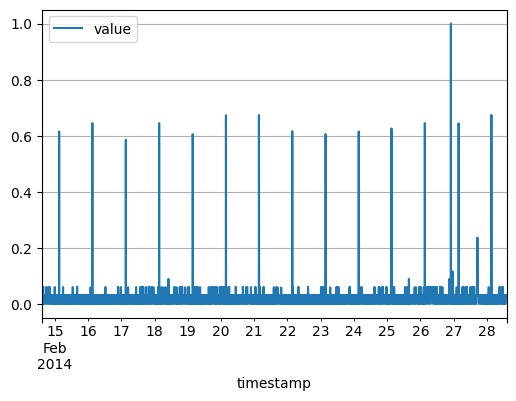

In [59]:
dataset_full.named_df_list['expert_0'].plot()

<Axes: xlabel='timestamp'>

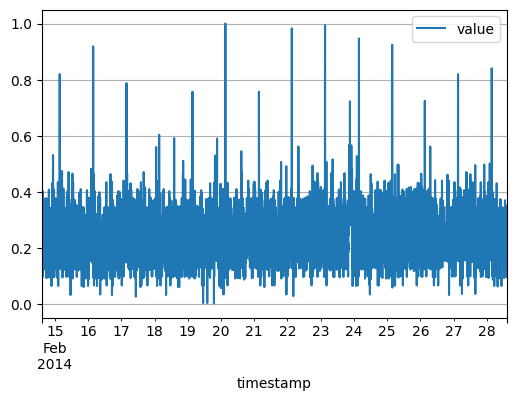

In [60]:
dataset_full.named_df_list['expert_1'].plot()

In [61]:
_return_dict = dataset_full[4000]
_return_dict.keys()

dict_keys(['expert_0', 'expert_1'])

In [62]:
_lags, _forecast, _date, _attention_mask = _return_dict['expert_0']
_lags.shape, _forecast.shape, _date.shape, _attention_mask.shape

(torch.Size([119, 1]),
 torch.Size([119, 1]),
 torch.Size([119, 3]),
 torch.Size([119]))

In [63]:
_attention_mask

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Train/Test Split

In [64]:
train_size = int(hyperparameters['split_ratio'] * len(dataset_full))
test_size = len(dataset_full) - train_size

train_size, test_size

(3225, 807)

### Random Index Sampling Train/Test Split

In [65]:
dataset_train, dataset_test = random_split(dataset_full, [train_size, test_size])
len(dataset_train), len(dataset_test)

(3225, 807)

# Dataloader

In [66]:
dataloader_full = DataLoader(
    dataset_full,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=hyperparameters['batch_size'],
    shuffle=True,
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

print(f'Number of batches (total): {len(dataloader_full)}')
print(f'Number of batches (train): {len(dataloader_train)}')
print(f'Number of batches (test): {len(dataloader_test)}')

Number of batches (total): 32
Number of batches (train): 26
Number of batches (test): 7


In [67]:
_return_dict_batch = next(iter(dataloader_full))

In [68]:
_lags_batch, _forecast_batch, _date_batch, _attention_mask_batch = _return_dict_batch['expert_0']

# (hyperparameters['batch_size'], hyperparameters['lags'], NUM_FEATURES), # (hyperparameters['batch_size'], hyperparameters['forecast'], NUM_FEATURES)

_lags_batch.shape, _forecast_batch.shape, _date_batch.shape, _attention_mask_batch.shape

(torch.Size([128, 119, 1]),
 torch.Size([128, 119, 1]),
 torch.Size([128, 119, 3]),
 torch.Size([128, 119]))

### Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [69]:
dataset_full.named_df_list['expert_0'].shape

(4032, 1)

### Update Hyperparamters for MoE

In [70]:
hyperparameters['num_experts'] = len(dataset_full.named_df_list)

# Training

### Training Functions
* with AMP support

In [71]:
def expert_train_iter(model, dataloader, optimizer, criterion, scaler, use_amp, device, expert_id):
    model.train()

    avg_loss = []
    
    for return_dict in dataloader:

        (lags, forecast, date, attention_mask) = return_dict[f'expert_{expert_id}']
        
        lags = lags.to(device)
        forecast = forecast.to(device)
        date = date.to(device)
        attention_mask = attention_mask.to(device)

        # remove device index (required for autocast device_type)
        if ':' in device:
            device_type = device.split(':')[0]
        else:
            device_type = device
            
        with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=use_amp):
            # AMP forward pass
            forecast_pred = model(x_input=lags, date_input=date, pad_mask=attention_mask)
            loss = criterion(forecast_pred, forecast)
        
        scaler.scale(loss).backward()  #loss.backward()
        scaler.step(optimizer)         #optimizer.step()
        scaler.update()
        optimizer.zero_grad()

        avg_loss.append(loss.item())

    return sum(avg_loss) / len(avg_loss)


@torch.no_grad()
def expert_eval_iter(model, dataloader, criterion, use_amp, device, expert_id):
    model.eval()

    avg_loss = []
    predictions = []
    
    for return_dict in dataloader:

        (lags, forecast, date, attention_mask) = return_dict[f'expert_{expert_id}']
    
        lags = lags.to(device)
        forecast = forecast.to(device)
        date = date.to(device)
        attention_mask = attention_mask.to(device)

        # remove device index (required for autocast device_type)
        if ':' in device:
            device_type = device.split(':')[0]
        else:
            device_type = device
        
        with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=use_amp):
            # AMP forward pass
            forecast_pred = model(x_input=lags, date_input=date, pad_mask=attention_mask)
            loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        predictions.append(forecast_pred)

    return sum(avg_loss) / len(avg_loss), predictions

### Expert Trainer Dict

In [72]:
# utiliy function
def print_model_parameters(model):
    print(f'{sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

In [73]:
expert_trainer_dict = {}

for expert_id in range(hyperparameters['num_experts']):
    expert_trainer_dict[f'expert_{expert_id}'] = {}
     
    # Transformer Model
    #_expert_model = deepcopy(model)

    """
    input_features_size=hyperparameters['input_features_size'],
    date_input_features_size=hyperparameters['date_input_features_size'],
    date_features_dim=hyperparameters['date_features_dim'],
    features_dim=hyperparameters['hidden_features_size'],
    output_features_size=hyperparameters['output_features_size'],
    num_heads=hyperparameters['num_heads'],
    ff_dim=hyperparameters['ff_dim'],
    num_decoder_layers=hyperparameters['num_decoder_layers'],
    emb_dropout_prob=hyperparameters['emb_dropout_prob'],
    attn_dropout_prob=hyperparameters['attn_dropout_prob'],
    ff_dropout_prob=hyperparameters['ff_dropout_prob'],
    attn_use_bias=hyperparameters['attn_use_bias'],
    ff_use_bias=hyperparameters['ff_use_bias'],
    output_features_bias=hyperparameters['output_features_bias'],
    """

    _expert_model = GPTTimeSeries(**expert_hyperparameters[f'expert_{expert_id}'])

    print(f'Number of parameters for expert {expert_id}:')
    print_model_parameters(_expert_model)
    
    # Loss, Optimizer, Scaler & Scheduler
    _optimizer = torch.optim.Adam(
        _expert_model.parameters(),
        lr=hyperparameters['learning_rate']
    )
    
    _scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        _optimizer,
        mode='min', 
        factor=0.1, 
        patience=3,
        min_lr=1e-6,
    )
    
    _scaler = torch.amp.GradScaler(enabled=hyperparameters['use_amp'])
    
    _criterion = nn.MSELoss()
        
    expert_trainer_dict[f'expert_{expert_id}']['model'] = _expert_model
    expert_trainer_dict[f'expert_{expert_id}']['optimizer'] = _optimizer
    expert_trainer_dict[f'expert_{expert_id}']['scheduler'] = _scheduler
    expert_trainer_dict[f'expert_{expert_id}']['scaler'] = _scaler
    expert_trainer_dict[f'expert_{expert_id}']['criterion'] = _criterion

Number of parameters for expert 0:
2,659,808
Number of parameters for expert 1:
2,659,808


#### Example Prediction

In [74]:
ex_expert_id = 0

# "1" is the batch, single sample to speed it up
dummy_data = torch.randn(1, hyperparameters['window_size'], expert_hyperparameters[f'expert_{ex_expert_id}']['input_features_size'])
dummy_date = torch.randn(1, hyperparameters['window_size'], expert_hyperparameters[f'expert_{ex_expert_id}']['date_input_features_size'])

o = expert_trainer_dict[f'expert_{ex_expert_id}']['model'](dummy_data, dummy_date)
o.shape

torch.Size([1, 32, 1])

# Devices for MoE
### Single GPU

In [75]:
for expert_id in range(len(expert_trainer_dict)):
    expert_trainer_dict[f'expert_{expert_id}']['device'] = 'cuda:0'

### Multiple GPU

In [76]:
# USE THIS IF YOU HAVE SECOND GPU
#expert_trainer_dict['expert_0']['device'] = 'cuda:0'
#expert_trainer_dict['expert_1']['device'] = 'cuda:1'

#### Final Expert Trainer Dict

In [77]:
expert_trainer_dict.keys(), expert_trainer_dict['expert_0'].keys()

(dict_keys(['expert_0', 'expert_1']),
 dict_keys(['model', 'optimizer', 'scheduler', 'scaler', 'criterion', 'device']))

In [78]:
def expert_trainer(hyperparameters, expert_trainer_dict):
    for epoch in range(1, hyperparameters['num_epochs']+1):
        for expert_id in range(len(expert_trainer_dict)):
            _model     = expert_trainer_dict[f'expert_{expert_id}']['model']
            _optimizer = expert_trainer_dict[f'expert_{expert_id}']['optimizer'] 
            _scheduler = expert_trainer_dict[f'expert_{expert_id}']['scheduler']
            _scaler    = expert_trainer_dict[f'expert_{expert_id}']['scaler']
            _criterion = expert_trainer_dict[f'expert_{expert_id}']['criterion']
            _device    = expert_trainer_dict[f'expert_{expert_id}']['device']

            _model.to(_device)
            
            avg_train_loss = expert_train_iter(
                model=_model, 
                dataloader=dataloader_train, 
                optimizer=_optimizer, 
                criterion=_criterion, 
                scaler=_scaler, 
                use_amp=hyperparameters['use_amp'], 
                device=_device,
                expert_id=expert_id,
            )
            
            avg_test_loss, _ = expert_eval_iter(
                model=_model, 
                dataloader=dataloader_test, 
                criterion=_criterion,
                use_amp=hyperparameters['use_amp'],
                device=_device,
                expert_id=expert_id,
            )
        
            # auto decrease LR when not improving
            _scheduler.step(avg_test_loss)
            
            print(f'Epoch: {epoch:<3}| Expert: {expert_id:>2}, Training loss: {avg_train_loss:.6f}, Testing Loss: {avg_test_loss:.6f}, LR: {_scheduler.get_last_lr()}')

            # save some memory
            torch.cuda.empty_cache()
            gc.collect()
            
        print()

### Start Training

In [79]:
expert_trainer(hyperparameters, expert_trainer_dict)

Epoch: 1  | Expert:  0, Training loss: 0.3117, Testing Loss: 0.0172, LR: [0.001]
Epoch: 1  | Expert:  1, Training loss: 0.7682, Testing Loss: 0.0118, LR: [0.001]

Epoch: 2  | Expert:  0, Training loss: 0.0062, Testing Loss: 0.0034, LR: [0.001]
Epoch: 2  | Expert:  1, Training loss: 0.0131, Testing Loss: 0.0106, LR: [0.001]

Epoch: 3  | Expert:  0, Training loss: 0.0023, Testing Loss: 0.0018, LR: [0.001]
Epoch: 3  | Expert:  1, Training loss: 0.0103, Testing Loss: 0.0100, LR: [0.001]

Epoch: 4  | Expert:  0, Training loss: 0.0019, Testing Loss: 0.0017, LR: [0.001]
Epoch: 4  | Expert:  1, Training loss: 0.0101, Testing Loss: 0.0100, LR: [0.001]

Epoch: 5  | Expert:  0, Training loss: 0.0019, Testing Loss: 0.0017, LR: [0.001]
Epoch: 5  | Expert:  1, Training loss: 0.0100, Testing Loss: 0.0099, LR: [0.001]

Epoch: 6  | Expert:  0, Training loss: 0.0019, Testing Loss: 0.0017, LR: [0.001]
Epoch: 6  | Expert:  1, Training loss: 0.0100, Testing Loss: 0.0099, LR: [0.001]

Epoch: 7  | Expert:  0

KeyboardInterrupt: 

# Save Model

In [80]:
os.makedirs('./saved_models', exist_ok=True)

expert_checkpoint_dict = {}

for expert_id in range(hyperparameters['num_experts']):
    checkpoint = {}
    
    checkpoint = {
        'model_state_dict': expert_trainer_dict[f'expert_{expert_id}']['model'].state_dict(),
        'optimizer_state_dict': expert_trainer_dict[f'expert_{expert_id}']['optimizer'].state_dict(),
        'hyperparameters': hyperparameters,
    }
    
    if hyperparameters['use_amp']:
        checkpoint['scaler_state_dict'] = expert_trainer_dict[f'expert_{expert_id}']['scaler'].state_dict()

    expert_checkpoint_dict[f'expert_{expert_id}'] = checkpoint


torch.save(
    expert_checkpoint_dict,
    './saved_models/GPTTimeSeries_Autoregressive_MoE.pt'
)

# Generative Forecast

In [81]:
@torch.no_grad()
def generative_forecast(model, data, timestamps, num_steps, lag_window_size, use_amp, device):
    model.eval()
    
    predictions = []
    time_indexes = []
    
    # covnert to tensor
    # data.shape: (lags, features)
    lags = torch.tensor(data[-lag_window_size:, :], dtype=torch.float32, device=device)
    
    # artificially add batch dimension
    # (we are not using the dataloader here!)
    # data.shape: (1, lags, features)
    lags = lags.unsqueeze(0)

    # Datetime indexes 
    #timestamps = df_full.index 
    # Delta time: calculate the time difference between two samples 
    delta_time = timestamps[1] - timestamps[0]
    # Get last timestamp
    current_timestamp = timestamps[-1]

    def generate_date_tensor(_timestamp, _lags, _device):
        _timestamp = _timestamp[-lag_window_size:]
        return torch.tensor([_timestamp.month, _timestamp.day, _timestamp.hour], dtype=torch.float32, device=_device).permute(1, 0)
    
    # single step
    for idx in tqdm(range(num_steps)):

        # get the last lag steps
        lags = lags[:, -lag_window_size:, :]
        #print(lags)

        # date
        date = generate_date_tensor(timestamps, lag_window_size, device).unsqueeze(0)

        # remove device index (required for autocast device_type)
        if ':' in device:
            device_type = device.split(':')[0]
        else:
            device_type = device
        
        with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=use_amp):
            # (attention mask is not required here)
            forecast_pred = model(lags, date)
        
        # (batch, forecast, output_features_size)-> (1, window_size-1, output_features_size)
        # TAKE THE LAST PREDICTION STEP AS FORECAST!
        predictions.append(forecast_pred[0][-1].cpu().numpy())

        # update current timestamp
        current_timestamp = current_timestamp + delta_time
        time_indexes.append(current_timestamp)
        
        # append last forecast to the end
        # TAKE THE LAST PREDICTION STEP AS FORECAST!
        lags = torch.cat((lags, forecast_pred[:, -1:, :].detach()), dim=1)
        
        # next timestamp
        timestamps = timestamps + delta_time

    return predictions, time_indexes

In [88]:
# select expert to generate
EXPERT_ID = 0
# features to forecast
SELECTED_FEATURES = 'value'
# should be min of original model
#REQUEST_WINDOW_SIZE = 200 * 2 # * 2 is added for convenience
REQUEST_WINDOW_SIZE = hyperparameters['window_size']
# temp dataframe for generative prediction input
df_temp = dataset_full.df_list[EXPERT_ID][-REQUEST_WINDOW_SIZE:]

if isinstance(df_temp, pd.Series):
    df_temp = df_temp.to_frame()

pred_generative, time_indexes_generative = generative_forecast(
    model=expert_trainer_dict[f'expert_{EXPERT_ID}']['model'], 
    data=df_temp.values,
    timestamps=df_temp.index,
    num_steps=hyperparameters['window_size'], 
    lag_window_size=hyperparameters['window_size'], 
    use_amp=hyperparameters['use_amp'], 
    device=expert_trainer_dict[f'expert_{EXPERT_ID}']['device']
)

pred_generative_array = np.array(pred_generative)

generative_results_dict = {}

# loop ove features
for feature_id, feature_key in enumerate(df_temp.columns):
    generative_results_dict[feature_key] = pred_generative_array[:, feature_id]
        
df_generative = pd.DataFrame(data=generative_results_dict, index=time_indexes_generative)

print(df_generative.head())

df_generative_unscaled = pd.DataFrame(
    data=expert_scaler_dict[f'expert_{EXPERT_ID}'].inverse_transform(df_generative),
    index=df_generative.index,
    columns=df_generative.columns
)

print(df_generative_unscaled.head())

"""
# REVERSE THE PREPROCESSING FOR ORIGINAL RANGE
df_generative[df_generative.columns] = dataset_full.scalers[EXPERT_ID].inverse_transform(df_generative[df_generative.columns])    

df_generative[SELECTED_FEATURES].plot(title='Generative Forecast')
dataset_full.named_df_list[f'expert_{EXPERT_ID}'][-hyperparameters['window_size']:].plot(title='Last Window')
"""

100%|██████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 97.70it/s]

                        value
2014-02-28 14:30:00  0.028076
2014-02-28 14:35:00  0.028061
2014-02-28 14:40:00  0.028046
2014-02-28 14:45:00  0.028046
2014-02-28 14:50:00  0.028046
                        value
2014-02-28 14:30:00  0.038544
2014-02-28 14:35:00  0.038177
2014-02-28 14:40:00  0.037811
2014-02-28 14:45:00  0.037811
2014-02-28 14:50:00  0.037811


"\n# REVERSE THE PREPROCESSING FOR ORIGINAL RANGE\ndf_generative[df_generative.columns] = dataset_full.scalers[EXPERT_ID].inverse_transform(df_generative[df_generative.columns])    \n\ndf_generative[SELECTED_FEATURES].plot(title='Generative Forecast')\ndataset_full.named_df_list[f'expert_{EXPERT_ID}'][-hyperparameters['window_size']:].plot(title='Last Window')\n"